# Gaspard
> Gaspard is a helper for Google's Gemini Models

In [ ]:
#| hide

from nbdev import show_doc
from fastcore.utils import *
from IPython import display

## Install

```sh
pip install gaspard
```

## Getting started

Follow the [instructions](https://aistudio.google.com/app/apikey) to generate an API key, and set it as an evironment variable as shown below:

```sh
export GEMINI_API_KEY=YOUR_API_KEY
```

Gemini's Python SDK will automatically be installed with Gaspard, if you don't already have it.

In [ ]:
from gaspard import *

Gaspard provides models, which lists the models available in the SDK

In [ ]:
models

('gemini-2.0-flash-exp',
 'gemini-exp-1206',
 'learnlm-1.5-pro-experimental',
 'gemini-exp-1121',
 'gemini-1.5-pro',
 'gemini-1.5-flash',
 'gemini-1.5-flash-8b')

For our examples we'll use `gemini-2.0-flash-exp` since it's awesome, has a 1M context window and is currently free while in the experimental stage.

In [ ]:
model = models[0]

## Chat

The main interface to Gaspard is the `Chat` class which provides a stateful interface to the models

In [ ]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")
chat("I'm Faisal")

Hi Faisal, it's nice to meet you!

<details>

- content: {'parts': [{'text': "Hi Faisal, it's nice to meet you!\n"}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.04827792942523956
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 14
- candidates_token_count: 12
- total_token_count: 26
- cached_content_token_count: 0

</details>

In [ ]:
r = chat("What's my name?")
r

Your name is Faisal.

<details>

- content: {'parts': [{'text': 'Your name is Faisal.\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -1.644962443000016e-05
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 35
- candidates_token_count: 6
- total_token_count: 41
- cached_content_token_count: 0

</details>

As you see above, displaying the results of a call in a notebook shows just the message contents, with the other details hidden behind a collapsible section. Alternatively you can print the details:



In [ ]:
print(r)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Your name is Faisal.\n"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "safety_ratings": [
            {
              "category": "HARM_CATEGORY_HATE_SPEECH",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HARASSMENT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
              "probability": "NEGLIGIBLE"
            }
          ],
          "avg_logprobs": -1.644962443000016e-05
        }
      ],
      "usage

You can use stream=True to stream the results as soon as they arrive (although you will only see the gradual generation if you execute the notebook yourself, of course!)

In [ ]:
chat.h

[{'role': 'user', 'parts': [{'text': "I'm Faisal"}, ' ']},
 {'role': 'model', 'parts': ["Hi Faisal, it's nice to meet you!\n"]},
 {'role': 'user', 'parts': [{'text': "What's my name?"}, ' ']},
 {'role': 'model', 'parts': ['Your name is Faisal.\n']}]

In [ ]:
for o in chat("What's your name? Tell me your story", stream=True): print(o, end='')

I don't have a name or a personal story in the way a human does. I am a large language model, created by Google AI. I was trained on a massive amount of text data to be able to communicate and generate human-like text. I don't have a body, feelings, or memories, but I'm here to help you with information and tasks.


Woah, welcome back to the land of the living Bard!

## Tool use

Tool use lets the model use external tools.

We use docments to make defining Python functions as ergonomic as possible. Each parameter (and the return value) should have a type, and a docments comment with the description of what it is. As an example we'll write a simple function that adds numbers together, and will tell us when it's being called:


In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

Sometimes the model will say something like "according to the sums tool the answer is" -- generally we'd rather it just tells the user the answer, so we can use a system prompt to help with this:

In [ ]:
sp = "Never mention what tools you use."

We'll get the model to add up some long numbers:

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

To use tools, pass a list of them to Chat:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])

Now when we call that with our prompt, the model doesn't return the answer, but instead returns a `function_call` message, which means we have to call the named function (tool) with the provided parameters:

In [ ]:
type(pr)

str

In [ ]:
r = chat(pr); r

Finding the sum of 604542.0 and 6458932.0


function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -9.219200364896096e-06
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 77
- candidates_token_count: 3
- total_token_count: 80
- cached_content_token_count: 0

</details>

Gaspard handles all that for us -- we just have to pass along the message, and it all happens automatically:

In [ ]:
chat.h

[{'role': 'user', 'parts': [{'text': 'What is 604542+6458932?'}, ' ']},
 {'role': 'model',
  'parts': [function_call {
     name: "sums"
     args {
       fields {
         key: "b"
         value {
           number_value: 6458932
         }
       }
       fields {
         key: "a"
         value {
           number_value: 604542
         }
       }
     }
   }]},
 {'role': 'user',
  'parts': [name: "sums"
   response {
     fields {
       key: "result"
       value {
         number_value: 7063474
       }
     }
   },
   {'text': ' '}]}]

In [ ]:
chat()

7063474

<details>

- content: {'parts': [{'text': '7063474\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.005276891868561506
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 128
- candidates_token_count: 8
- total_token_count: 136
- cached_content_token_count: 0

</details>

We can inspect the history to see what happens under the hood. Gaspard calls the tool with the appropriate variables returned by the `function_call` message from the model. The result of calling the function is then sent back to the model, which uses that to respond to the user. 

In [ ]:
chat.h[-3:]

[{'role': 'model',
  'parts': [function_call {
     name: "sums"
     args {
       fields {
         key: "b"
         value {
           number_value: 6458932
         }
       }
       fields {
         key: "a"
         value {
           number_value: 604542
         }
       }
     }
   }]},
 {'role': 'user',
  'parts': [name: "sums"
   response {
     fields {
       key: "result"
       value {
         number_value: 7063474
       }
     }
   },
   {'text': ' '}]},
 {'role': 'model', 'parts': ['7063474\n']}]

You can see how many tokens have been used at any time by checking the `use` property.

In [ ]:
chat.use

In: 205; Out: 11; Total: 216

## Tool loop

We can do everything needed to use tools in a single step, by using Chat.toolloop. This can even call multiple tools as needed solve a problem. For example, let's define a tool to handle multiplication:

In [ ]:
def mults(
    a:int,  # First thing to multiply
    b:int=1 # Second thing to multiply
) -> int: # The product of the inputs
    "Multiplies a * b."
    print(f"Finding the product of {a} and {b}")
    return a * b

Now with a single call we can calculate `(a+b)*2` -- by passing `show_trace` we can see each response from the model in the process:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums,mults])
pr = f'Calculate ({a}+{b})*2'
pr

'Calculate (604542+6458932)*2'

In [ ]:
def pchoice(r): print(r.parts[0])

In [ ]:
r = chat.toolloop(pr, trace_func=pchoice)

Finding the sum of 604542.0 and 6458932.0
function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

Finding the product of 7063474.0 and 2.0
function_call {
  name: "mults"
  args {
    fields {
      key: "b"
      value {
        number_value: 2
      }
    }
    fields {
      key: "a"
      value {
        number_value: 7063474
      }
    }
  }
}

text: "(604542+6458932)*2 = 14126948\n"



We can see from the trace above that the model correctly calls the sums function first to add the numbers inside the parenthesis and then calls the mults function to multiply the result of the summation by `2`. The response sent back to the user is the actual result after performing the chained tool calls, shown below:

In [ ]:
r

(604542+6458932)*2 = 14126948

<details>

- content: {'parts': [{'text': '(604542+6458932)*2 = 14126948\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.00017791306267359426
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 229
- candidates_token_count: 28
- total_token_count: 257
- cached_content_token_count: 0

</details>

## Structured Outputs

If you just want the immediate result from a single tool, use `Client.structured`.

In [ ]:
cli = Client(model)

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
cli.structured("What is 604542+6458932", sums)

Finding the sum of 604542.0 and 6458932.0


[7063474.0]

This is particularly useful for getting back structured information, e.g:

In [ ]:
class President(BasicRepr):
    "Information about a president of the United States"
    def __init__(self, 
                first:str, # first name
                last:str, # last name
                spouse:str, # name of spouse
                years_in_office:str, # format: "{start_year}-{end_year}"
                birthplace:str, # name of city
                birth_year:int # year of birth, `0` if unknown
        ):
        assert re.match(r'\d{4}-\d{4}', years_in_office), "Invalid format: `years_in_office`"
        store_attr()

In [ ]:
cli.structured("Provide key information about the 3rd President of the United States", President)[0]

President(first='Thomas', last='Jefferson', spouse='Martha Wayles Skelton', years_in_office='1801-1809', birthplace='Shadwell', birth_year=1743.0)

## Images

As everyone knows, when testing image APIs you have to use a cute puppy. But, that's boring, so here's a baby hippo instead.

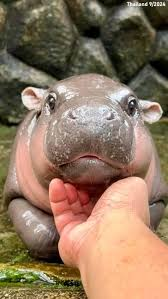

In [ ]:
img_fn = Path('samples/baby_hippo.jpg')
display.Image(filename=img_fn, width=200)

We create a `Chat` object as before:

In [ ]:
chat = Chat(model)

For Gaspard, we can simply pass `Path` objects that repsent the path of the images. To pass multi-part messages, such as an image along with a prompt, we simply pass in a list of items. Note that Gaspard expects each item to be a text or a `Path` object.

In [ ]:
chat([img_fn, "In brief, is happening in the photo?"])

Certainly!

In the photo, a person's hand is gently touching the chin of a baby hippopotamus. The hippo is sitting on the ground and appears to be looking straight at the camera.
<details>

- content: {'parts': [{'text': "Certainly!\n\nIn the photo, a person's hand is gently touching the chin of a baby hippopotamus. The hippo is sitting on the ground and appears to be looking straight at the camera."}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.3545633316040039
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 268
- candidates_token_count: 40
- total_token_count: 308
- cached_content_token_count: 0

</details>

Under the hood, Gaspard uploads the image using Gemini's `File API` and passes a reference to the model. Gemini API will automatically infer the MIME type, and convert it appropriately. NOTE that the image is also included in input tokens.

In [ ]:
chat.use

In: 268; Out: 40; Total: 308

Alternatively, Gaspard supports creating a multi-stage chat with separate image and text prompts. For instance, you can pass just the image as the initial prompt (in which case the model will make some general comments about what it sees, which can be VERY detailed depending on the model and often begin with "Certainly!" for some reason), and then follow up with questions in additional prompts:

In [ ]:
chat = Chat(model)
chat(img_fn)

Certainly! Here's a description of the image you sent:

**Overall Scene:**

The image is a close-up shot of a baby hippopotamus being gently petted by a human hand. The scene is heartwarming and focuses on the interaction between the adorable hippo calf and the human. 

**Baby Hippo:**

*   **Appearance:** The hippo is a very young calf with a plump, rounded body. Its skin is a mottled gray color, with hints of pink especially around its neck and cheeks. Its eyes are dark and soulful, giving it an endearing expression. The calf has a small, broad snout and tiny, rounded ears.
*   **Pose:** The hippo is sitting with its short legs tucked beneath its body. It's looking directly at the camera with a slightly curious and passive expression. 
*   **Texture:** The hippo's skin appears smooth and moist, suggesting it might be wet or freshly out of the water.

**Human Hand:**

*   **Position:** The hand is placed gently under the hippo's chin and neck, supporting its head. The fingers are slightly curved and not gripping tightly, demonstrating a caring touch.
*   **Texture:** The skin of the hand appears soft and well-maintained.

**Background:**

*   **Setting:** The background is out of focus, but it appears to be a rocky, possibly aquatic, environment. The textures in the background are muted and do not detract from the main subjects of the photo.
*  **Date**: There's a watermark saying "Thailand 9/2024", indicating the location and date of the image.

**Mood/Tone:**

*   The image evokes a sense of gentleness and tenderness. The close-up perspective and the gentle touch of the hand create a very intimate and sweet scene.
*   The calf's innocent expression adds to the overall cuteness and warmth of the image.

**Overall Impression:**

The image captures a beautiful moment of interaction between a human and a very young, vulnerable animal. The photograph emphasizes the gentle nature of the interaction and the sheer adorableness of the baby hippo, making it a very touching and memorable picture.

Let me know if you would like a description from another perspective or have any other questions about the image!
<details>

- content: {'parts': [{'text': 'Certainly! Here\'s a description of the image you sent:\n\n**Overall Scene:**\n\nThe image is a close-up shot of a baby hippopotamus being gently petted by a human hand. The scene is heartwarming and focuses on the interaction between the adorable hippo calf and the human. \n\n**Baby Hippo:**\n\n*   **Appearance:** The hippo is a very young calf with a plump, rounded body. Its skin is a mottled gray color, with hints of pink especially around its neck and cheeks. Its eyes are dark and soulful, giving it an endearing expression. The calf has a small, broad snout and tiny, rounded ears.\n*   **Pose:** The hippo is sitting with its short legs tucked beneath its body. It\'s looking directly at the camera with a slightly curious and passive expression. \n*   **Texture:** The hippo\'s skin appears smooth and moist, suggesting it might be wet or freshly out of the water.\n\n**Human Hand:**\n\n*   **Position:** The hand is placed gently under the hippo\'s chin and neck, supporting its head. The fingers are slightly curved and not gripping tightly, demonstrating a caring touch.\n*   **Texture:** The skin of the hand appears soft and well-maintained.\n\n**Background:**\n\n*   **Setting:** The background is out of focus, but it appears to be a rocky, possibly aquatic, environment. The textures in the background are muted and do not detract from the main subjects of the photo.\n*  **Date**: There\'s a watermark saying "Thailand 9/2024", indicating the location and date of the image.\n\n**Mood/Tone:**\n\n*   The image evokes a sense of gentleness and tenderness. The close-up perspective and the gentle touch of the hand create a very intimate and sweet scene.\n*   The calf\'s innocent expression adds to the overall cuteness and warmth of the image.\n\n**Overall Impression:**\n\nThe image captures a beautiful moment of interaction between a human and a very young, vulnerable animal. The photograph emphasizes the gentle nature of the interaction and the sheer adorableness of the baby hippo, making it a very touching and memorable picture.\n\nLet me know if you would like a description from another perspective or have any other questions about the image!'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.7025935932741327
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 260
- candidates_token_count: 472
- total_token_count: 732
- cached_content_token_count: 0

</details>

In [ ]:
chat('What direction is the hippo facing?')

The hippo is facing directly towards the camera.

<details>

- content: {'parts': [{'text': 'The hippo is facing directly towards the camera.\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.06370497941970825
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 742
- candidates_token_count: 10
- total_token_count: 752
- cached_content_token_count: 0

</details>

In [ ]:
chat('What color is it?')

The hippo is a mottled gray color, with hints of pink especially around its neck and cheeks.

<details>

- content: {'parts': [{'text': 'The hippo is a mottled gray color, with hints of pink especially around its neck and cheeks.\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.08235452175140381
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 760
- candidates_token_count: 20
- total_token_count: 780
- cached_content_token_count: 0

</details>

Note that the image is passed in again for every input in the dialog, via the chat history, so the number of input tokens increases quickly with this kind of chat.

In [ ]:
chat.use

In: 1762; Out: 502; Total: 2264

## Other Media

Beyond images, we can also pass in other kind of media to Gaspard, such as audio file, video files, documents, etc.

For example, let's try to send a pdf file to the model.

In [ ]:
pdf_fn = Path('samples/attention_is_all_you_need.pdf')

In [ ]:
chat = Chat(model)

In [ ]:
chat([pdf_fn, "In brief, what are the main ideas of this paper?"])

Certainly! Here's a breakdown of the main ideas presented in the paper "Attention is All You Need":

**Core Contribution: The Transformer Architecture**

*   **Rejection of Recurrence and Convolution:** The paper proposes a novel neural network architecture called the "Transformer" that moves away from traditional recurrent neural networks (RNNs) and convolutional neural networks (CNNs). These are the common architectures for tasks involving sequence data.
*   **Sole Reliance on Attention:** The Transformer relies solely on the "attention" mechanism to capture relationships within input and output sequences. This is the core novel idea and is in contrast to models using attention *in addition to* RNNs or CNNs.
*   **Parallelizable:** By removing recurrence, the Transformer is highly parallelizable, which allows for faster training, especially on GPUs.
*   **Attention-Based Encoder-Decoder:** The Transformer uses an encoder-decoder architecture, like other sequence-to-sequence models, but the encoder and decoder are based on self-attention mechanisms rather than RNNs or CNNs.

**Key Components of the Transformer:**

*   **Multi-Head Attention:** The Transformer uses multiple "attention heads," each learning different dependencies. This allows the model to capture information from different representation sub-spaces.
    *   **Self-Attention:** Attention mechanism is applied on the same sequence (e.g. input to input or output to output), to capture relations within the sequence itself.
    *   **Encoder-Decoder Attention:** Attention mechanism is applied on two sequences (encoder and decoder output) to align sequences between the source and target.
*   **Scaled Dot-Product Attention:** A specific form of attention that uses dot products to calculate the attention weights with a scaling factor to stabilize the training.
*   **Position-wise Feed-Forward Networks:**  Fully connected networks are applied to each position separately after attention to add non-linearity.
*   **Positional Encoding:**  Since the Transformer doesn't have inherent recurrence or convolutions, positional encodings are added to the input embeddings to encode the sequence order.

**Experimental Results and Impact:**

*   **Superior Translation Quality:** The paper demonstrates the effectiveness of the Transformer on machine translation tasks (English-to-German and English-to-French). The models achieve state-of-the-art results with significant BLEU score improvements over existing models including RNN and CNN based approaches.
*   **Faster Training:** They show that the Transformer achieves those state-of-the-art results with much less training time compared to other architectures, showing the benefit of parallelization.
*   **Generalization to Other Tasks:** The Transformer is also shown to work well on English constituency parsing, highlighting its ability to handle other sequence-based problems.
*   **Interpretability:** Through attention visualizations, the paper also suggests that the model learns to capture structural information in the input, making it more interpretable than recurrent methods.

**In Essence:**

The paper argues for attention as a foundational building block for sequence processing, dispensing with the need for recurrence and convolutions. It introduces the Transformer, a model that leverages attention mechanisms to achieve both better performance and faster training, setting a new state-of-the-art baseline for many tasks such as machine translation.

Let me know if you'd like any specific aspect clarified further!

<details>

- content: {'parts': [{'text': 'Certainly! Here\'s a breakdown of the main ideas presented in the paper "Attention is All You Need":\n\n**Core Contribution: The Transformer Architecture**\n\n*   **Rejection of Recurrence and Convolution:** The paper proposes a novel neural network architecture called the "Transformer" that moves away from traditional recurrent neural networks (RNNs) and convolutional neural networks (CNNs). These are the common architectures for tasks involving sequence data.\n*   **Sole Reliance on Attention:** The Transformer relies solely on the "attention" mechanism to capture relationships within input and output sequences. This is the core novel idea and is in contrast to models using attention *in addition to* RNNs or CNNs.\n*   **Parallelizable:** By removing recurrence, the Transformer is highly parallelizable, which allows for faster training, especially on GPUs.\n*   **Attention-Based Encoder-Decoder:** The Transformer uses an encoder-decoder architecture, like other sequence-to-sequence models, but the encoder and decoder are based on self-attention mechanisms rather than RNNs or CNNs.\n\n**Key Components of the Transformer:**\n\n*   **Multi-Head Attention:** The Transformer uses multiple "attention heads," each learning different dependencies. This allows the model to capture information from different representation sub-spaces.\n    *   **Self-Attention:** Attention mechanism is applied on the same sequence (e.g. input to input or output to output), to capture relations within the sequence itself.\n    *   **Encoder-Decoder Attention:** Attention mechanism is applied on two sequences (encoder and decoder output) to align sequences between the source and target.\n*   **Scaled Dot-Product Attention:** A specific form of attention that uses dot products to calculate the attention weights with a scaling factor to stabilize the training.\n*   **Position-wise Feed-Forward Networks:**  Fully connected networks are applied to each position separately after attention to add non-linearity.\n*   **Positional Encoding:**  Since the Transformer doesn\'t have inherent recurrence or convolutions, positional encodings are added to the input embeddings to encode the sequence order.\n\n**Experimental Results and Impact:**\n\n*   **Superior Translation Quality:** The paper demonstrates the effectiveness of the Transformer on machine translation tasks (English-to-German and English-to-French). The models achieve state-of-the-art results with significant BLEU score improvements over existing models including RNN and CNN based approaches.\n*   **Faster Training:** They show that the Transformer achieves those state-of-the-art results with much less training time compared to other architectures, showing the benefit of parallelization.\n*   **Generalization to Other Tasks:** The Transformer is also shown to work well on English constituency parsing, highlighting its ability to handle other sequence-based problems.\n*   **Interpretability:** Through attention visualizations, the paper also suggests that the model learns to capture structural information in the input, making it more interpretable than recurrent methods.\n\n**In Essence:**\n\nThe paper argues for attention as a foundational building block for sequence processing, dispensing with the need for recurrence and convolutions. It introduces the Transformer, a model that leverages attention mechanisms to achieve both better performance and faster training, setting a new state-of-the-art baseline for many tasks such as machine translation.\n\nLet me know if you\'d like any specific aspect clarified further!\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.7809832342739763
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 14943
- candidates_token_count: 696
- total_token_count: 15639
- cached_content_token_count: 0

</details>

We can pass in audio files in the same way.

In [ ]:
audio_fn = Path('samples/attention_is_all_you_need.mp3')

In [ ]:
pr = "This is a podcast about the same paper. What important details from the paper are not in the podcast?"

In [ ]:
chat([audio_fn, pr])

Okay, let's analyze what details were missing from the podcast discussion of "Attention is All You Need". Here are some of the key aspects not fully covered:

**1. Deeper Dive into the Math and Mechanics:**

*   **Detailed Attention Formula:** The podcast mentions "scaled dot product attention" but doesn't delve into the actual mathematical formula used to calculate the attention weights:
    *   `Attention(Q, K, V) = softmax((QK^T) / sqrt(d_k)) * V` (where Q=query, K=key, V=value, and d_k is the dimension of the key)
*   **Query, Key, Value:** While mentioned, the exact nature of how Query, Key and Values are generated from input is never made explicit. How are these generated by linear transformations is an essential aspect.
*   **The role of the Mask:** The mask in decoder's self-attention is also not covered in depth. Masking is essential for the auto-regressive nature of the output sequence.
*   **Positional Encoding Equations:** The podcast mentioned positional encoding but not the specific sine and cosine formulas and their purpose which are key to how the model retains position information.
    *   `PE(pos, 2i) = sin(pos/10000^(2i/d_model))`
    *   `PE(pos, 2i+1) = cos(pos/10000^(2i/d_model))`
*   **Detailed explanation of how d_model, d_k, d_v and head dimension relate.** This is essential to understanding the parameter counts in the model.

**2. Architectural Details and Hyperparameters:**

*   **Number of Layers and Model Dimensions:** The paper uses 6 layers both on the encoder and decoder side in their basic and large models. The exact dimensionality of the model itself is also crucial to understanding its capacity. The podcast only mentions that they are stacked.
*   **Feed Forward Layer Details:** The point-wise feed-forward network's dimensionality is essential for model performance. The podcast does not go into depth about it and the dimensionality being used d_ff=2048 is key.
*   **Dropout and Label Smoothing:** They are mentioned as a type of regularization, but the specific rates of 0.1 for the base model are never mentioned nor is the label smoothing rate of 0.1. These details are important for reproducibility and performance.
*   **Optimization Details:** There is also no mention of the Adam Optimizer's Beta parameters of β₁ = 0.9, β2 = 0.98 and € = 10-9. The paper introduces a specific learning rate decay that is not discussed by name.

**3. Analysis and Experiments:**

*   **Comparison to other attention-based models:** The paper explains its motivations in relation to other attention-based models (such as memory networks).
*   **Model variation experiments:** The paper contains detailed experiments varying attention head number and dimensionality, different position encoding options, and impact of dropout and size that are not discussed.
*   **Computational Complexity:** The paper explains detailed complexity analysis for different layer types (Recurrent, Convolutional etc) and their implications for training performance, which is only vaguely discussed in the podcast.
*   **Attention Interpretations:** The paper visually highlights patterns in attention weights which provide intuition on what the model is learning, which is not really discussed by name. This allows insights into how the model handles long-distance dependencies.

**4. Technical Implementation:**

*   **Byte-pair encoding:** While mentioned, this subword approach and its impact on vocabulary size and performance is never fully discussed.
*   **Batching:** Batching of training examples using the total sequence length is discussed, but the method of how they are batched in terms of approximately 25000 tokens is not explicit in the podcast.
*   **Ensemble method:** Details about how checkpointing and averaging are used to generate model predictions is missing.

**5. Broader Context and Future Work**

*   **Why sinusoidal encodings:** The paper specifically states that they hypothesized that using fixed functions for position encoding should be better than learning them, this explanation is not given in the podcast.
*   **Future Directions:** The paper explicitly lays out plans to extend the transformer to handle larger inputs using locality restrictions and applying them to other modalities, which was alluded to, but not explored with the same depth.

**In Summary:**

The podcast provides a good overview of the high-level ideas of the paper, but it omits several crucial technical details, mathematical equations, model architecture configurations, and experimental analysis. These omissions are quite critical for fully grasping the novelty and impact of the paper's findings, and for anyone interested in implementing or extending the model. The podcast lacks the quantitative analysis and model variations that the paper presents.

<details>

- content: {'parts': [{'text': 'Okay, let\'s analyze what details were missing from the podcast discussion of "Attention is All You Need". Here are some of the key aspects not fully covered:\n\n**1. Deeper Dive into the Math and Mechanics:**\n\n*   **Detailed Attention Formula:** The podcast mentions "scaled dot product attention" but doesn\'t delve into the actual mathematical formula used to calculate the attention weights:\n    *   `Attention(Q, K, V) = softmax((QK^T) / sqrt(d_k)) * V` (where Q=query, K=key, V=value, and d_k is the dimension of the key)\n*   **Query, Key, Value:** While mentioned, the exact nature of how Query, Key and Values are generated from input is never made explicit. How are these generated by linear transformations is an essential aspect.\n*   **The role of the Mask:** The mask in decoder\'s self-attention is also not covered in depth. Masking is essential for the auto-regressive nature of the output sequence.\n*   **Positional Encoding Equations:** The podcast mentioned positional encoding but not the specific sine and cosine formulas and their purpose which are key to how the model retains position information.\n    *   `PE(pos, 2i) = sin(pos/10000^(2i/d_model))`\n    *   `PE(pos, 2i+1) = cos(pos/10000^(2i/d_model))`\n*   **Detailed explanation of how d_model, d_k, d_v and head dimension relate.** This is essential to understanding the parameter counts in the model.\n\n**2. Architectural Details and Hyperparameters:**\n\n*   **Number of Layers and Model Dimensions:** The paper uses 6 layers both on the encoder and decoder side in their basic and large models. The exact dimensionality of the model itself is also crucial to understanding its capacity. The podcast only mentions that they are stacked.\n*   **Feed Forward Layer Details:** The point-wise feed-forward network\'s dimensionality is essential for model performance. The podcast does not go into depth about it and the dimensionality being used d_ff=2048 is key.\n*   **Dropout and Label Smoothing:** They are mentioned as a type of regularization, but the specific rates of 0.1 for the base model are never mentioned nor is the label smoothing rate of 0.1. These details are important for reproducibility and performance.\n*   **Optimization Details:** There is also no mention of the Adam Optimizer\'s Beta parameters of β₁ = 0.9, β2 = 0.98 and € = 10-9. The paper introduces a specific learning rate decay that is not discussed by name.\n\n**3. Analysis and Experiments:**\n\n*   **Comparison to other attention-based models:** The paper explains its motivations in relation to other attention-based models (such as memory networks).\n*   **Model variation experiments:** The paper contains detailed experiments varying attention head number and dimensionality, different position encoding options, and impact of dropout and size that are not discussed.\n*   **Computational Complexity:** The paper explains detailed complexity analysis for different layer types (Recurrent, Convolutional etc) and their implications for training performance, which is only vaguely discussed in the podcast.\n*   **Attention Interpretations:** The paper visually highlights patterns in attention weights which provide intuition on what the model is learning, which is not really discussed by name. This allows insights into how the model handles long-distance dependencies.\n\n**4. Technical Implementation:**\n\n*   **Byte-pair encoding:** While mentioned, this subword approach and its impact on vocabulary size and performance is never fully discussed.\n*   **Batching:** Batching of training examples using the total sequence length is discussed, but the method of how they are batched in terms of approximately 25000 tokens is not explicit in the podcast.\n*   **Ensemble method:** Details about how checkpointing and averaging are used to generate model predictions is missing.\n\n**5. Broader Context and Future Work**\n\n*   **Why sinusoidal encodings:** The paper specifically states that they hypothesized that using fixed functions for position encoding should be better than learning them, this explanation is not given in the podcast.\n*   **Future Directions:** The paper explicitly lays out plans to extend the transformer to handle larger inputs using locality restrictions and applying them to other modalities, which was alluded to, but not explored with the same depth.\n\n**In Summary:**\n\nThe podcast provides a good overview of the high-level ideas of the paper, but it omits several crucial technical details, mathematical equations, model architecture configurations, and experimental analysis. These omissions are quite critical for fully grasping the novelty and impact of the paper\'s findings, and for anyone interested in implementing or extending the model. The podcast lacks the quantitative analysis and model variations that the paper presents.\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -1.2337962527821222
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 23502
- candidates_token_count: 1039
- total_token_count: 24541
- cached_content_token_count: 0

</details>

You should be careful and monitor usage as the token usage rack up really fast! 

In [ ]:
chat.use

In: 38445; Out: 1735; Total: 40180

We can also use structured outputs with multi-modal data:

In [ ]:
class AudioMetadata(BasicRepr):
    """Class to hold metadata for audio files"""
    def __init__(
        self,
        n_speakers:int, # Number of speakers
        topic:str, # Topic discussed
        summary:str, # 100 word summary
        transcript:list[str], # Transcript of the audio segmented by speaker
    ): store_attr()
pr = "Extract the necessary information from the audio."

In [ ]:
audio_md = cli.structured(mk_msgs([[audio_fn, pr]]), tools=[AudioMetadata])[0]

In [ ]:
print(f'Number of speakers: {audio_md.n_speakers}')
print(f'Topic: {audio_md.topic}')
print(f'Summary: {audio_md.summary}')
transcript = '\n-'.join(list(audio_md.transcript)[:10])
print(f'Transcript: {transcript}')

Number of speakers: 2.0
Topic: Machine Learning and NLP
Summary: This podcast discusses the 'Attention is All You Need' research paper by Vaswani et al., focusing on the Transformer model's architecture, its use of attention mechanisms, and its performance on translation tasks.
Transcript: Welcome to our podcast, where we dive into groundbreaking research papers. Today, we're discussing 'Attention is all you need' by Vaswani at all. Joining us is an expert in machine learning. Welcome.
-Thanks for having me. I'm excited to discuss this revolutionary paper.
-Let's start with the core idea. What's the main thrust of this research?
-The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models.
-That sounds like a significant departure from previous approaches. What motivated this radical change?
-The main motivation